<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_merge_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot

     |████████████████████████████████| 61 kB 23 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Default GPU Device: /device:GPU:0
True
2.8.0
2.8.0


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


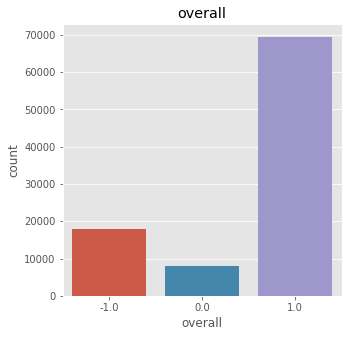

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


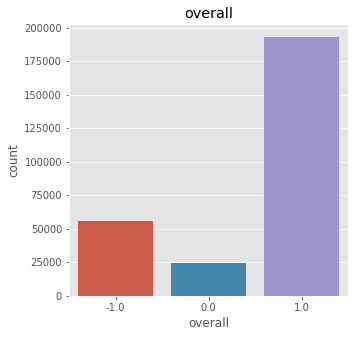

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


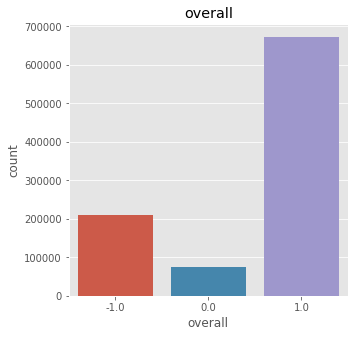

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


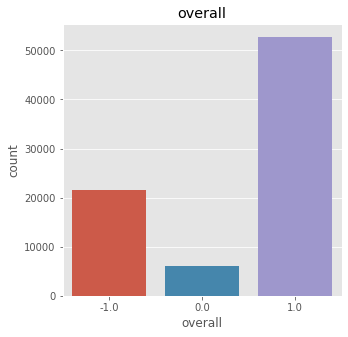

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5000 positive，5000 negative，5000 neutral

80%(12000) training and 20%(3000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4000,:]
  train_neudata = neu.iloc[:4000,:]
  train_negdata = neg.iloc[:4000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4000:5000,:]
  test_neudata = neu.iloc[4000:5000,:]
  test_negdata = neg.iloc[4000:5000,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1997 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df1_test.shape

(3000, 3)

## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText,cleanText
3923,2.0,2001,"Being a Roller Coaster Tycoon fan, I bought th...",roller coaster tycoon fan bought expecting sim...
23371,0.0,2001,The sims house party is the expansion of the s...,sims house party expansion sims sims livin lar...
4109,1.0,2001,"This game is as good as tehy come. Sure, ther...",game good tehy come sure games better engines ...
34606,0.0,2003,I just bought this game. I decided to wait unt...,bought game decided wait got cheap spend money...
61900,0.0,2005,"First off, the DDR series of games is one of t...",first ddr series games best createdinventeddev...


## Merge train&test data

Extract 25% data from each time period and combine train&test

In [ ]:
def merge(df1,df2,df3,df4,rate):
  sample1 = df1.sample(frac=rate,replace=False,random_state=None,axis=0) # sample frac rate of rows from the dataframe without replacement
  sample2 = df2.sample(frac=rate,replace=False,random_state=None,axis=0)
  sample3 = df3.sample(frac=rate,replace=False,random_state=None,axis=0)
  sample4 = df4.sample(frac=rate,replace=False,random_state=None,axis=0)

  merged = pd.concat([sample1, sample2, sample3, sample4],sort=False).sample(frac=1.0)

  return merged

In [ ]:
train_merged = merge(df1_train,df2_train,df3_train,df4_train,0.25)
test_merged = merge(df1_test,df2_test,df3_test,df4_test,0.25)

In [ ]:
train_merged.shape

(12000, 4)

In [ ]:
test_merged.shape

(3000, 4)

## Text Tokenization

In [ ]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

47761 words are used
Training:
Average length of each row >> 75.64791666666666
Maximum length of each row >> 1734


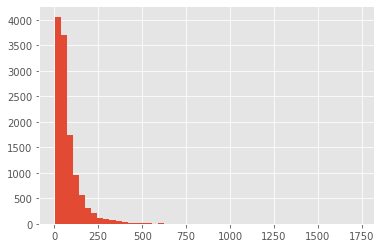

Testing
Average length of each row >> 75.62933333333334
Maximum length of each row >> 835


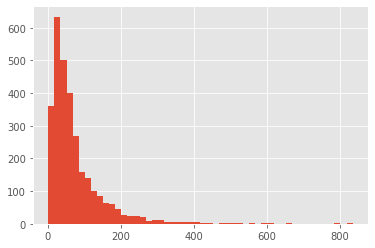

max sequence length:  1734


In [ ]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

34449 words are used
Training:
Average length of each row >> 57.553916666666666
Maximum length of each row >> 1384


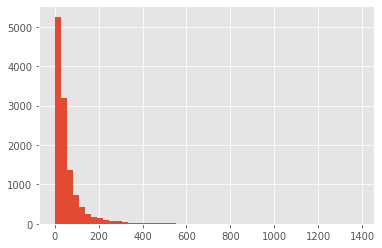

Testing
Average length of each row >> 56.823
Maximum length of each row >> 1149


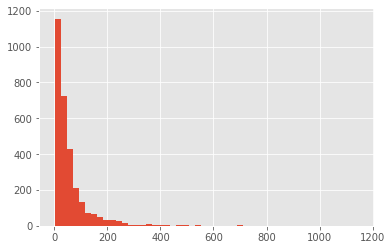

max sequence length:  1384


In [ ]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

19298 words are used
Training:
Average length of each row >> 25.603583333333333
Maximum length of each row >> 1527


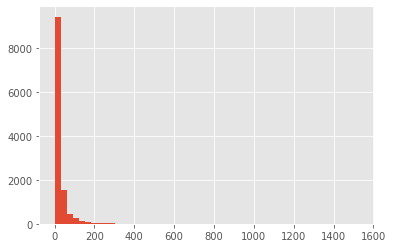

Testing
Average length of each row >> 24.920666666666666
Maximum length of each row >> 528


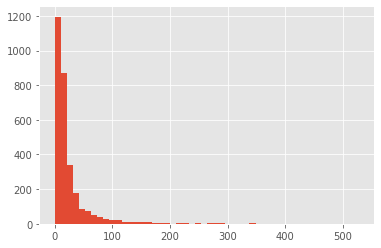

max sequence length:  1527


In [ ]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

14430 words are used
Training:
Average length of each row >> 18.97525
Maximum length of each row >> 595


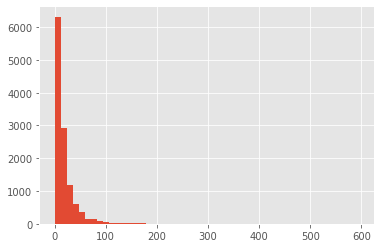

Testing
Average length of each row >> 19.109333333333332
Maximum length of each row >> 269


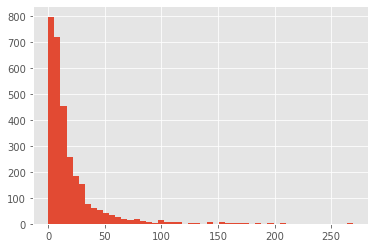

max sequence length:  595


In [ ]:
df4_train_fea,df4_test_fea,df4_vocab_size,df4_maxlen = tokenize(df4_train["cleanText"],df4_test["cleanText"])

31959 words are used
Training:
Average length of each row >> 44.77316666666667
Maximum length of each row >> 1527


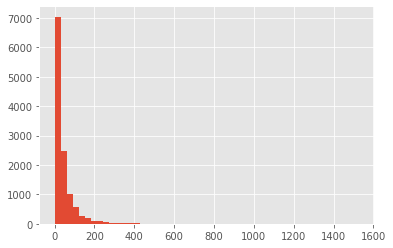

Testing
Average length of each row >> 45.008
Maximum length of each row >> 1143


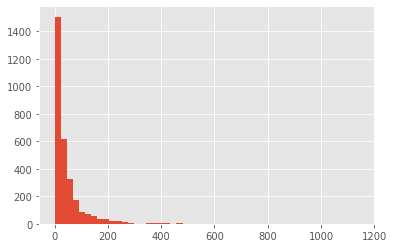

max sequence length:  1527


In [ ]:
merge_train_fea,merge_test_fea,merge_vocab_size,merge_maxlen = tokenize(train_merged["cleanText"],test_merged["cleanText"])

## Padding

In [ ]:
sequence_size = 400
print("max sequence length for game: ",sequence_size)

max sequence length for game:  400


In [ ]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

df4_train_pad = pad_sequences(df4_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_test_pad = pad_sequences(df4_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_train_label = to_categorical(df4_train.overall,num_classes=3)
df4_test_label = to_categorical(df4_test.overall,num_classes=3)

merge_train_pad = pad_sequences(merge_train_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_test_pad = pad_sequences(merge_test_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_train_label = to_categorical(train_merged.overall,num_classes=3)
merge_test_label = to_categorical(test_merged.overall,num_classes=3)

## Build LSTM Model and Train on merged train

In [ ]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 256
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,df4_vocab_size,merge_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  47761


In [ ]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [ ]:
bilstm = bilstm_model()
plot_model(bilstm)
lstm_no_hist = bilstm.fit(merge_train_pad,merge_train_label,epochs=epochs,batch_size=batch_size,validation_data=(merge_test_pad,merge_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          4776100   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 256)         234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 32)                3276832   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

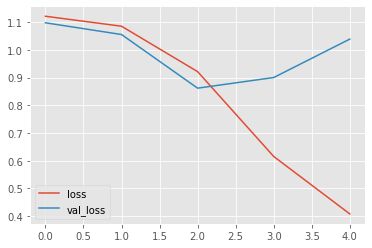

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

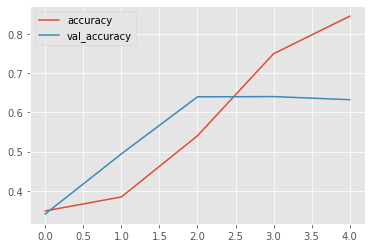

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
bilstm.save('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')

## Evaluate on each time period data

In [ ]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df1_test_pad,df1_test_label)

94/94 [==============================] - 3s 20ms/step - loss: 2.2121 - accuracy: 0.3587


[2.212127685546875, 0.35866665840148926]

In [ ]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df2_test_pad,df2_test_label)

94/94 [==============================] - 2s 17ms/step - loss: 2.0943 - accuracy: 0.3470


[2.0943124294281006, 0.34700000286102295]

In [ ]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df3_test_pad,df3_test_label)

94/94 [==============================] - 3s 17ms/step - loss: 1.7560 - accuracy: 0.3353


[1.7559536695480347, 0.33533334732055664]

In [ ]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df4_test_pad,df4_test_label)

94/94 [==============================] - 3s 17ms/step - loss: 1.7341 - accuracy: 0.3207


[1.7340997457504272, 0.32066667079925537]

## Fine tune on 1997-2006

21977 words are used
Training:
Average length of each row >> 76.48833333333333
Maximum length of each row >> 797


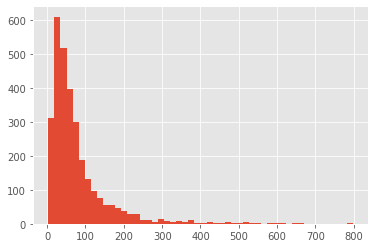

Testing
Average length of each row >> 72.176
Maximum length of each row >> 635


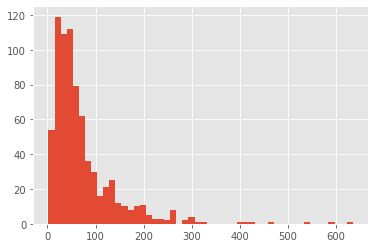

max sequence length:  797


In [ ]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')

df1_sample_train = df1_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df1_sample_test = df1_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df1_sample_train_fea,df1_sample_test_fea,df1_sample_vocab_size,df1_sample_maxlen = tokenize(df1_sample_train["cleanText"],df1_sample_test["cleanText"])

In [ ]:
df1_sample_train_pad = pad_sequences(df1_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_sample_test_pad = pad_sequences(df1_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_sample_train_label = to_categorical(df1_sample_train.overall,num_classes=3)
df1_sample_test_label = to_categorical(df1_sample_test.overall,num_classes=3)

In [ ]:
merged_lstm.fit(df1_sample_train_pad,df1_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_sample_test_pad,df1_sample_test_label),callbacks=[es])

Epoch 1/8
12/12 [==============================] - 1s 107ms/step - loss: 1.0850 - accuracy: 0.3417 - val_loss: 1.1006 - val_accuracy: 0.3333
Epoch 2/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0789 - accuracy: 0.3480 - val_loss: 1.1050 - val_accuracy: 0.3133
Epoch 3/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0699 - accuracy: 0.3710 - val_loss: 1.1049 - val_accuracy: 0.3213
Epoch 4/8
12/12 [==============================] - 1s 100ms/step - loss: 1.0684 - accuracy: 0.3750 - val_loss: 1.1225 - val_accuracy: 0.3253
Epoch 5/8
12/12 [==============================] - 1s 102ms/step - loss: 1.0547 - accuracy: 0.3897 - val_loss: 1.1747 - val_accuracy: 0.3133
Epoch 6/8
12/12 [==============================] - 1s 100ms/step - loss: 1.0389 - accuracy: 0.4233 - val_loss: 1.1113 - val_accuracy: 0.3227
Epoch 6: early stopping


## Fine tune on 2007-2012

16248 words are used
Training:
Average length of each row >> 57.675
Maximum length of each row >> 929


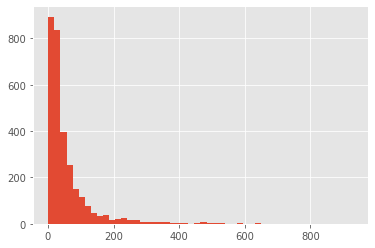

Testing
Average length of each row >> 57.95733333333333
Maximum length of each row >> 1089


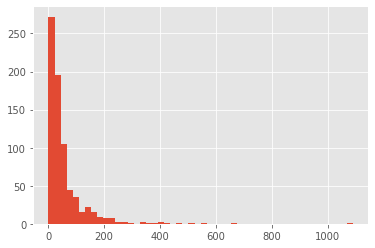

max sequence length:  1089


In [ ]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')

df2_sample_train = df2_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df2_sample_test = df2_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df2_sample_train_fea,df2_sample_test_fea,df2_sample_vocab_size,df2_sample_maxlen = tokenize(df2_sample_train["cleanText"],df2_sample_test["cleanText"])

In [ ]:
df2_sample_train_pad = pad_sequences(df2_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_sample_test_pad = pad_sequences(df2_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_sample_train_label = to_categorical(df2_sample_train.overall,num_classes=3)
df2_sample_test_label = to_categorical(df2_sample_test.overall,num_classes=3)

In [ ]:
merged_lstm.fit(df2_sample_train_pad,df2_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df2_sample_test_pad,df2_sample_test_label),callbacks=[es])

Epoch 1/8
12/12 [==============================] - 5s 202ms/step - loss: 1.3570 - accuracy: 0.3460 - val_loss: 1.0969 - val_accuracy: 0.3507
Epoch 2/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0911 - accuracy: 0.3763 - val_loss: 1.2821 - val_accuracy: 0.3493
Epoch 3/8
12/12 [==============================] - 1s 104ms/step - loss: 1.1111 - accuracy: 0.3960 - val_loss: 1.0840 - val_accuracy: 0.3840
Epoch 4/8
12/12 [==============================] - 1s 100ms/step - loss: 1.0804 - accuracy: 0.3977 - val_loss: 1.0858 - val_accuracy: 0.3907
Epoch 5/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0766 - accuracy: 0.4097 - val_loss: 1.0783 - val_accuracy: 0.3960
Epoch 6/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0606 - accuracy: 0.4270 - val_loss: 1.0724 - val_accuracy: 0.4053
Epoch 6: early stopping


## Fine tune on 2013-2017

9348 words are used
Training:
Average length of each row >> 25.19333333333333
Maximum length of each row >> 1527


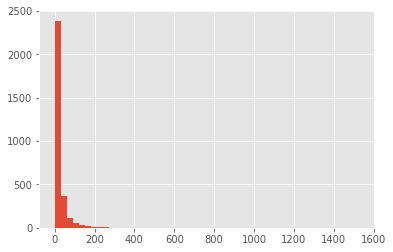

Testing
Average length of each row >> 25.138666666666666
Maximum length of each row >> 355


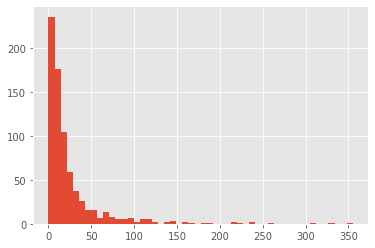

max sequence length:  1527


In [ ]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')

df3_sample_train = df3_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df3_sample_test = df3_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df3_sample_train_fea,df3_sample_test_fea,df3_sample_vocab_size,df3_sample_maxlen = tokenize(df3_sample_train["cleanText"],df3_sample_test["cleanText"])

In [ ]:
df3_sample_train_pad = pad_sequences(df3_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_sample_test_pad = pad_sequences(df3_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_sample_train_label = to_categorical(df3_sample_train.overall,num_classes=3)
df3_sample_test_label = to_categorical(df3_sample_test.overall,num_classes=3)

In [ ]:
merged_lstm.fit(df3_sample_train_pad,df3_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df3_sample_test_pad,df3_sample_test_label),callbacks=[es])

Epoch 1/8
12/12 [==============================] - 4s 170ms/step - loss: 1.2537 - accuracy: 0.3590 - val_loss: 1.0972 - val_accuracy: 0.3920
Epoch 2/8
12/12 [==============================] - 1s 102ms/step - loss: 1.0910 - accuracy: 0.3920 - val_loss: 1.0852 - val_accuracy: 0.3827
Epoch 3/8
12/12 [==============================] - 1s 103ms/step - loss: 1.0830 - accuracy: 0.4087 - val_loss: 1.0835 - val_accuracy: 0.4280
Epoch 4/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0786 - accuracy: 0.4007 - val_loss: 1.0806 - val_accuracy: 0.4373
Epoch 5/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0643 - accuracy: 0.4327 - val_loss: 1.0677 - val_accuracy: 0.4480
Epoch 6/8
12/12 [==============================] - 1s 102ms/step - loss: 1.0530 - accuracy: 0.4363 - val_loss: 1.0596 - val_accuracy: 0.4800
Epoch 6: early stopping


## Fine tune on 2018

7068 words are used
Training:
Average length of each row >> 18.918666666666667
Maximum length of each row >> 376


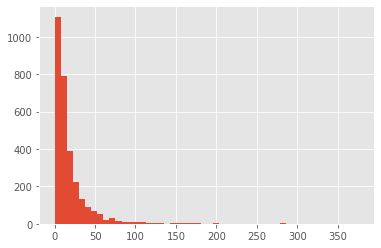

Testing
Average length of each row >> 20.470666666666666
Maximum length of each row >> 248


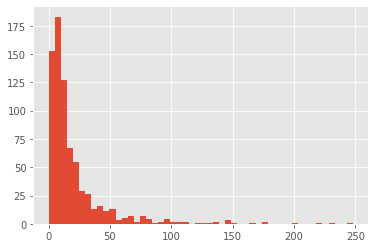

max sequence length:  376


In [ ]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_merge.h5')

df4_sample_train = df4_train.sample(frac=0.25,replace=False,random_state=None,axis=0)
df4_sample_test = df4_test.sample(frac=0.25,replace=False,random_state=None,axis=0)

df4_sample_train_fea,df4_sample_test_fea,df4_sample_vocab_size,df4_sample_maxlen = tokenize(df4_sample_train["cleanText"],df4_sample_test["cleanText"])

In [ ]:
df4_sample_train_pad = pad_sequences(df4_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_sample_test_pad = pad_sequences(df4_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_sample_train_label = to_categorical(df4_sample_train.overall,num_classes=3)
df4_sample_test_label = to_categorical(df4_sample_test.overall,num_classes=3)

In [ ]:
merged_lstm.fit(df4_sample_train_pad,df4_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df4_sample_test_pad,df4_sample_test_label),callbacks=[es])

Epoch 1/8
12/12 [==============================] - 5s 169ms/step - loss: 1.2191 - accuracy: 0.3633 - val_loss: 1.0904 - val_accuracy: 0.3880
Epoch 2/8
12/12 [==============================] - 1s 101ms/step - loss: 1.0865 - accuracy: 0.3913 - val_loss: 1.0868 - val_accuracy: 0.3453
Epoch 3/8
12/12 [==============================] - 1s 102ms/step - loss: 1.0786 - accuracy: 0.3933 - val_loss: 1.0803 - val_accuracy: 0.3813
Epoch 4/8
12/12 [==============================] - 1s 102ms/step - loss: 1.0746 - accuracy: 0.4070 - val_loss: 1.0728 - val_accuracy: 0.4387
Epoch 5/8
12/12 [==============================] - 1s 103ms/step - loss: 1.0646 - accuracy: 0.4313 - val_loss: 1.0708 - val_accuracy: 0.3773
Epoch 6/8
12/12 [==============================] - 1s 102ms/step - loss: 1.0548 - accuracy: 0.4320 - val_loss: 1.0547 - val_accuracy: 0.4773
Epoch 6: early stopping
